<a href="https://colab.research.google.com/github/kota-mizu/AB_test/blob/main/inference_notebook/15.80_8.83_Inf_7/30days_feature_added.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://signate.jp/competitions/1634



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# セットアップ

In [ ]:
!pip install holidays

In [ ]:
# ライブラリのインポート
import os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

from IPython.display import display
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score



warnings.filterwarnings("ignore")

# 日本語フォントを簡単に使う
!pip -q install japanize-matplotlib
import japanize_matplotlib

# データの読み込み

In [ ]:
data_path = '/content/drive/MyDrive/signate_smbc/'
submission_path = '/content/drive/MyDrive/signate_smbc/submission/'

In [ ]:
train_raw_df  = pd.read_csv(data_path + 'train.csv')
test_raw_df   = pd.read_csv(data_path + 'test.csv')
sample_submission_df = pd.read_csv(data_path + 'sample_submit.csv', header=None)  # header 無し
feature_description = pd.read_csv(data_path + 'feature_description.csv', index_col = 0)

# 前処理
 目的: データをモデルが扱える状態に整える
 - 欠損値の補完
 - データ型の変換 (例: time列をdatetimeへ)
 - カテゴリ変数の基本的なエンコーディング (One-Hotなど)
 ★この処理は関数化するのが望ましい (例: def preprocess(df):)

In [ ]:
#前処理用にコピーを作成
train_df = train_raw_df.copy()
test_df = test_raw_df.copy()

In [ ]:
train_df.head()

,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,seville_weather_main,seville_weather_description,seville_weather_icon,price_actual
0,2015-01-02 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,33,0.0,0.0,0.0,0,800,clear,sky is clear,01n,64.02
1,2015-01-02 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,33,0.0,0.0,0.0,0,800,clear,sky is clear,01n,58.46
2,2015-01-02 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,54.70
3,2015-01-02 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,54.91
4,2015-01-02 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,53.07


In [ ]:
# 前処理の対象の特徴量をリストアップ
train_selected = train_df.copy()
test_selected = test_df.copy()

#### wind_speed*3を作成する関数


In [ ]:
# def add_wind_potential_features(df):
#     """
#     DataFrameに5都市それぞれの風力ポテンシャル特徴量を追加する関数。
#     """
#     # 元のDataFrameを変更しないようにコピーを作成
#     df_processed = df.copy()

#     # 都市名のリスト
#     cities = ['valencia', 'madrid', 'bilbao', 'barcelona', 'seville']

#     # 削除対象となる元のカラム名を格納するリスト
#     original_wind_cols_to_drop = []

#     # 各都市についてループ処理
#     for city in cities:
#         wind_speed_col = f'{city}_wind_speed'
#         wind_potential_col = f'{city}_wind_potential'

#         if wind_speed_col in df_processed.columns:
#             # 新しい特徴量を作成
#             df_processed[wind_potential_col] = df_processed[wind_speed_col] ** 3
#             # 削除リストに元のカラム名を追加
#             original_wind_cols_to_drop.append(wind_speed_col)
#         else:
#             print(f"警告: カラム '{wind_speed_col}' が見つかりませんでした。")

#     # ループの後に、リストアップしたカラムをまとめて削除
#     if original_wind_cols_to_drop:
#         df_processed.drop(columns=original_wind_cols_to_drop, inplace=True)

#     return df_processed

# # 学習データに適用
# train_selected = add_wind_potential_features(train_selected)

# # テストデータに適用
# test_selected = add_wind_potential_features(test_selected)

#### 再生可能エネルギー以外の不足分を作成する関数

In [ ]:
# def add_renewable_shortfall_feature(df):
#     """
#     DataFrameに「総再生可能エネルギー発電量では賄いきれない需要」
#     を示す 'renewable_shortfall' 特徴量を追加する関数。

#     Args:
#         df (pd.DataFrame): 処理対象のDataFrame。
#                            'total_load_actual' と各種発電量カラムを含む必要がある。

#     Returns:
#         pd.DataFrame: 'renewable_shortfall' カラムが追加された新しいDataFrame。
#     """
#     # 元のDataFrameを変更しないようにコピーを作成
#     df_processed = df.copy()

#     # 再生可能エネルギーに該当するカラムのリストを定義
#     renewable_cols = [
#         'generation_biomass',
#         'generation_hydro_run_of_river_and_poundage',
#         'generation_hydro_water_reservoir',
#         'generation_other_renewable',
#         'generation_solar',
#         'generation_waste',
#         'generation_wind_onshore'
#     ]

#     # DataFrameに存在する再エネカラムのみを対象にする
#     existing_renewable_cols = [col for col in renewable_cols if col in df_processed.columns]

#     # 1. 各行の総再生可能エネルギー発電量を計算
#     df_processed['total_renewable_generation'] = df_processed[existing_renewable_cols].sum(axis=1)

#     # 2. 「総需要」から「総再エネ発電量」を引いて、賄いきれない需要（不足分）を計算
#     df_processed['renewable_shortfall'] = df_processed['total_load_actual'] - df_processed['total_renewable_generation']

#     # 3. 不足分がマイナスになる場合（再エネが需要を上回る場合）は0にクリップする
#     df_processed['renewable_shortfall'] = df_processed['renewable_shortfall'].clip(lower=0)

#     # 中間的に作成した総再エネ発電量の列は不要なので削除
#     df_processed.drop(columns=['total_renewable_generation'], inplace=True)

#     return df_processed

# train_selected = add_renewable_shortfall_feature(train_selected)
# test_selected = add_renewable_shortfall_feature(test_selected)

#### 再生可能エネルギー発電量比率関数を作成する関数

In [ ]:
def add_renewable_share_feature(df):
    """
    DataFrameに「総発電量に占める、再生可能エネルギー発電量の比率」
    を示す 'renewable_share' 特徴量を追加する関数。

    Args:
        df (pd.DataFrame): 処理対象のDataFrame。
                           各種発電量カラムを含む必要がある。

    Returns:
        pd.DataFrame: 'renewable_share' カラムが追加された新しいDataFrame。
    """
    # 元のDataFrameを変更しないようにコピーを作成
    df_processed = df.copy()

    # --- 1. 各発電カテゴリのカラムを定義 ---

    # 再生可能エネルギーに該当するカラム
    renewable_cols = [
        'generation_biomass',
        'generation_hydro_run_of_river_and_poundage',
        'generation_hydro_water_reservoir',
        'generation_other_renewable',
        'generation_solar',
        'generation_waste',
        'generation_wind_onshore'
    ]

    # 「発電量（供給）」と見なせる全てのカラム
    # 揚水発電の「消費」は供給ではないため除外する
    all_supply_cols = [col for col in df_processed.columns if 'generation' in col and 'consumption' not in col]

    # DataFrameに存在するカラムのみを対象にする
    existing_renewable_cols = [col for col in renewable_cols if col in df_processed.columns]

    # --- 2. 各発電量を計算 ---

    # 総再生可能エネルギー発電量を計算
    df_processed['total_renewable_generation'] = df_processed[existing_renewable_cols].sum(axis=1)

    # 総発電量（総供給量）を計算
    df_processed['total_generation'] = df_processed[all_supply_cols].sum(axis=1)

    # --- 3. 比率を計算 ---

    # 「総再エネ発電量」を「総発電量」で割り、比率を計算
    df_processed['renewable_share'] = df_processed['total_renewable_generation'] / df_processed['total_generation']

    # 0除算によって発生した無限大(inf)や欠損値(NaN)を0で埋める
    df_processed['renewable_share'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_processed['renewable_share'].fillna(0, inplace=True)

    # 中間的に作成した列は不要なので削除
    df_processed.drop(columns=['total_renewable_generation', 'total_generation'], inplace=True)

    return df_processed

train_selected = add_renewable_share_feature(train_selected)
test_selected = add_renewable_share_feature(test_selected)

再エネ比率の方が再エネで賄えない消費量よりもスコアは改善

#### 正味水力発電量の30日間移動統計量を作成する関数

In [ ]:
# --- 2. 正味水力発電量の30日間移動統計量を作成する関数 ---
def add_hydro_rolling_features(df, window_days=30):
    """
    DataFrameに「正味の水力発電量」の移動平均と移動標準偏差を追加する関数。

    Args:
        df (pd.DataFrame): 処理対象のDataFrame。
        window_days (int): 移動統計量を計算する期間（日数）。

    Returns:
        pd.DataFrame: 新しい特徴量が追加されたDataFrame。
    """
    if df is None: return None
    df_processed = df.copy()

    # --- 事前準備: 'net_hydro_generation' を関数内で作成 ---
    hydro_gen_cols = [
        'generation_hydro_water_reservoir'
    ]
    hydro_consumption_col = 'generation_hydro_pumped_storage_consumption'

    # 計算前に欠損値を0で埋める
    for col in hydro_gen_cols + [hydro_consumption_col]:
        if col in df_processed.columns:
            df_processed[col].fillna(0, inplace=True)

    # 正味の水力発電量を計算
    df_processed['net_hydro_generation'] = (
        df_processed[hydro_gen_cols].sum(axis=1) - df_processed[hydro_consumption_col]
    )

    # # --- 移動統計量の計算 ---
    # # ウィンドウサイズを時間単位に変換（データは1時間ごとのため）
    # window_size_hours = window_days * 24

    # # 計算対象のカラム
    # col_to_roll = 'net_hydro_generation'

    # print(f"'{col_to_roll}'の{window_days}日間移動統計量を作成します...")

    # # 新しいカラム名
    # mean_col_name = f'{col_to_roll}_rolling_mean_{window_days}d'
    # std_col_name = f'{col_to_roll}_rolling_std_{window_days}d'

    # # 移動平均と移動標準偏差を計算
    # df_processed[mean_col_name] = df_processed[col_to_roll].rolling(window=window_size_hours, min_periods=1).mean()
    # df_processed[std_col_name] = df_processed[col_to_roll].rolling(window=window_size_hours, min_periods=1).std()

    # print("特徴量の作成が完了しました。")
    return df_processed


train_selected = add_hydro_rolling_features(train_selected)
test_selected = add_hydro_rolling_features(test_selected)

In [ ]:
train_selected.head()

,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,seville_weather_main,seville_weather_description,seville_weather_icon,price_actual,renewable_share,net_hydro_generation
0,2015-01-02 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,0.0,0.0,0,800,clear,sky is clear,01n,64.02,0.368519,1036.0
1,2015-01-02 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,0.0,0.0,0,800,clear,sky is clear,01n,58.46,0.346569,738.0
2,2015-01-02 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,0.0,0.0,0,800,clear,sky is clear,01n,54.70,0.334426,207.0
3,2015-01-02 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,0.0,0.0,0,800,clear,sky is clear,01n,54.91,0.325464,-724.0
4,2015-01-02 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,0.0,0.0,0,800,clear,sky is clear,01n,53.07,0.322058,-1106.0


## 処理するカラム選択

In [ ]:
#この先の処理で使用するカラムの選択
use_cols = [
    "time",
    'total_load_actual',
    'generation_solar',
    'generation_wind_onshore',
    'generation_fossil_gas',
    'generation_fossil_hard_coal',
    'generation_fossil_oil',
    # 'generation_fossil_brown_coal/lignite',
    "madrid_temp",
    "valencia_temp",
    "bilbao_temp",
    "barcelona_temp",
    "seville_temp",
    "madrid_wind_speed",
    "valencia_wind_speed",
    "bilbao_wind_speed",
    "barcelona_wind_speed",
    "seville_wind_speed",
    # "renewable_share",
    # "madrid_clouds_all",
    # "valencia_clouds_all",
    # "bilbao_clouds_all",
    # "barcelona_clouds_all",
    # "seville_clouds_all",
    # "madrid_snow_3h",
    # "valencia_snow_3h",
    # "bilbao_snow_3h",
    # "barcelona_snow_3h", #barcelonaは雪が降っていない
    # "seville_snow_3h", #train
    "net_hydro_generation",
    # "net_hydro_generation_rolling_mean_30d",
    # "net_hydro_generation_rolling_std_30d",
    "price_actual"
]

train_selected = train_selected[use_cols]
test_selected = test_selected[use_cols[:-1]]

In [ ]:
# 欠損値補完
train_selected.ffill(inplace=True)
test_selected.ffill(inplace=True)

## 標準化するカラム選択

In [ ]:
# 標準化するカラムの選択
scale_cols = [
     'total_load_actual',
    'generation_solar',
    'generation_wind_onshore',
    # 'generation_hydro_run_of_river_and_poundage',
    'generation_fossil_gas',
    'generation_fossil_hard_coal',
    'generation_fossil_oil',
    "madrid_wind_speed",
    "valencia_wind_speed",
    "bilbao_wind_speed",
    "barcelona_wind_speed",
    "seville_wind_speed",
    "net_hydro_generation",
    ]
# OKのデータフレームで作成
train_ok = train_selected.copy()

In [ ]:
# OK 版：行 t 以前だけで平均・標準偏差を更新しながら標準化（expanding().mean()/std() を使う）
for col in scale_cols:
    # 平均と標準偏差を逐次更新
    train_ok[f"{col}_mean_to_t"] = train_ok[col].expanding().mean()
    train_ok[f"{col}_std_to_t"]  = train_ok[col].expanding().std(ddof=0)

    # 0除算を避けるため std==0 の行は NaN に
    train_ok[f"{col}_scaled"] = (
        (train_ok[col] - train_ok[f"{col}_mean_to_t"]) /
        train_ok[f"{col}_std_to_t"]
    )



In [ ]:
train_ok.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 55 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   time                                   26280 non-null  object 
 1   total_load_actual                      26280 non-null  float64
 2   generation_solar                       26280 non-null  float64
 3   generation_wind_onshore                26280 non-null  float64
 4   generation_fossil_gas                  26280 non-null  float64
 5   generation_fossil_hard_coal            26280 non-null  float64
 6   generation_fossil_oil                  26280 non-null  float64
 7   madrid_temp                            26280 non-null  float64
 8   valencia_temp                          26280 non-null  float64
 9   bilbao_temp                            26280 non-null  float64
 10  barcelona_temp                         26280 non-null  float64
 11  se

In [ ]:
print("◆ OK（リークなし）")
display(train_ok[[*(f"{c}_scaled" for c in scale_cols) ]].head())

◆ OK（リークなし）


,total_load_actual_scaled,generation_solar_scaled,generation_wind_onshore_scaled,generation_fossil_gas_scaled,generation_fossil_hard_coal_scaled,generation_fossil_oil_scaled,madrid_wind_speed_scaled,valencia_wind_speed_scaled,bilbao_wind_speed_scaled,barcelona_wind_speed_scaled,seville_wind_speed_scaled,net_hydro_generation_scaled
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,NaN,NaN,-1.000000,NaN,NaN,-1.000000
2,-1.311200,0.707107,-1.197652,-0.666844,-1.363200,-0.925820,NaN,NaN,-0.707107,NaN,1.414214,-1.322193
3,-1.379864,0.577350,-1.156156,-1.549117,-1.637686,0.390567,NaN,NaN,-0.577350,NaN,1.000000,-1.552069
4,-1.345247,-1.984572,-1.275557,-1.380235,-1.544575,-1.207020,NaN,NaN,-0.500000,NaN,0.816497,-1.377108


In [ ]:
test_ok = test_selected.copy()
for col in scale_cols:
    mu_train = train_ok[f"{col}_mean_to_t"].iloc[-1]
    std_train = train_ok[f"{col}_std_to_t"].iloc[-1]
    test_ok[f"{col}_scaled"] = (test_ok[col] - mu_train) / std_train

In [ ]:
#標準偏差と平均と元データを消す
std_mean_cols = [c for c in train_ok.columns if c.endswith("_std_to_t") or c.endswith("_mean_to_t")]
drop_cols = std_mean_cols + scale_cols
train_ok.drop(columns=drop_cols, inplace=True)

In [ ]:
display(train_ok)

,time,madrid_temp,valencia_temp,bilbao_temp,barcelona_temp,seville_temp,price_actual,total_load_actual_scaled,generation_solar_scaled,generation_wind_onshore_scaled,generation_fossil_gas_scaled,generation_fossil_hard_coal_scaled,generation_fossil_oil_scaled,madrid_wind_speed_scaled,valencia_wind_speed_scaled,bilbao_wind_speed_scaled,barcelona_wind_speed_scaled,seville_wind_speed_scaled,net_hydro_generation_scaled
0,2015-01-02 00:00:00+01:00,267.129,271.229,273.474656,282.779,276.529,64.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02 01:00:00+01:00,267.129,271.229,272.502500,282.779,276.529,58.46,-1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,NaN,NaN,-1.000000,NaN,NaN,-1.000000
2,2015-01-02 02:00:00+01:00,266.389,270.664,272.732344,281.864,276.314,54.70,-1.311200,0.707107,-1.197652,-0.666844,-1.363200,-0.925820,NaN,NaN,-0.707107,NaN,1.414214,-1.322193
3,2015-01-02 03:00:00+01:00,266.389,270.664,272.060656,281.864,276.314,54.91,-1.379864,0.577350,-1.156156,-1.549117,-1.637686,0.390567,NaN,NaN,-0.577350,NaN,1.000000,-1.552069
4,2015-01-02 04:00:00+01:00,266.389,270.664,272.093000,281.864,276.314,53.07,-1.345247,-1.984572,-1.275557,-1.380235,-1.544575,-1.207020,NaN,NaN,-0.500000,NaN,0.816497,-1.377108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26275,2017-12-31 19:00:00+01:00,282.910,290.150,281.670000,287.150,289.940,39.90,0.096297,-0.826966,0.732572,-0.704249,-1.680952,-1.774078,1.799861,1.266087,0.080014,1.056217,0.856574,1.176540
26276,2017-12-31 20:00:00+01:00,281.960,290.150,281.180000,288.270,289.330,39.54,0.172537,-0.838793,0.684704,-0.722716,-1.673928,-1.551847,2.303325,1.636907,0.080012,1.551859,1.400125,1.171493
26277,2017-12-31 21:00:00+01:00,281.810,289.150,281.680000,288.150,288.940,32.90,0.160668,-0.840544,0.685944,-0.745145,-1.676272,-1.403685,0.792204,1.265921,-0.457285,2.047386,0.312879,1.074288
26278,2017-12-31 22:00:00+01:00,281.580,290.150,280.690000,287.150,288.540,23.85,-0.064553,-0.841109,0.596211,-0.672051,-1.735304,-1.459128,1.799464,2.007567,-0.457275,0.560274,-0.774355,0.919433


# 特徴量エンジニアリング
 目的: モデルの精度を向上させるための新しい特徴量を作成する
 - 時間特徴量の作成 (hour, dayofweek, is_holidayなど)
 - 気象特徴量の作成 (temp_deviationなど)
 - ラグ特徴量、移動統計量の作成
 - 交互作用特徴量の作成
 ★この処理も特徴量の種類ごとに関数化するのが望ましい (例: def create_time_features(df):)

In [ ]:
train_df = train_ok.copy()
test_df = test_ok.copy()

#### brown_coal_binnedを作成する関数。

In [ ]:
# def add_binned_brown_coal_feature(df, drop_original=True):
#     """
#     'generation_fossil_brown_coal/lignite' をビニングしてカテゴリ特徴量を作成する関数。

#     Args:
#         df (pd.DataFrame): 処理対象のDataFrame。
#         drop_original (bool): Trueの場合、元のカラムを削除する。デフォルトはTrue。

#     Returns:
#         pd.DataFrame: ビニングされた新しいカラムが追加されたDataFrame。
#     """
#     # 元のDataFrameを変更しないようにコピーを作成
#     df_processed = df.copy()

#     source_col = 'generation_fossil_brown_coal/lignite'
#     new_col = 'brown_coal_binned'

#     # カラムが存在するかチェック
#     if source_col not in df_processed.columns:
#         print(f"警告: カラム '{source_col}' が見つかりませんでした。スキップします。")
#         return df_processed

#     # 1. ビニングの境界値を定義
#     #    -infはマイナス無限大。0を明確に区切るため、下限を-1などに設定するのも一般的。
#     #    境界値は .describe() の結果 (min:0, 50%:352, max:959) を参考に設定。
#     bins = [-np.inf, 0, np.inf]

#     # 2. 各ビンに対応するラベルを定義
#     # labels = ['Off', 'Low-Mid_Power', 'High_Power']
#     labels =  [0, 1]

#     # 3. pd.cut を使ってビニングを実行
#     df_processed[new_col] = pd.cut(
#         df_processed[source_col],
#         bins=bins,
#         labels=labels,
#         right=True # 区間の右側を含む (例: (0, 564] は 0 < x <= 564)
#     )

#     # 4. 元のカラムを削除する場合
#     if drop_original:
#         df_processed.drop(columns=[source_col], inplace=True)
#         print(f"元のカラム '{source_col}' を削除しました。")

#     return df_processed

# train_df = add_binned_brown_coal_feature(train_df)
# test_df = add_binned_brown_coal_feature(test_df)

#### temp_deviationを追加する関数。

In [ ]:
def create_city_temp_deviation_features(df):
    """
    DataFrameに5都市それぞれの気温偏差特徴量を追加する関数。
    """
    # 元のDataFrameを変更しないようにコピーを作成
    df_processed = df.copy()

    # 都市名のリスト
    cities = ['valencia', 'madrid', 'bilbao', 'barcelona', 'seville']

    # 快適温度を定義（この値は調整可能です）
    COMFORT_TEMP = 17.5

    print(f"各都市の「快適温度({COMFORT_TEMP}℃)からの差」を特徴量として作成します...")

    # 各都市についてループ処理
    for city in cities:
        # 関連するカラム名を定義
        temp_k_col = f'{city}_temp'          # 元のケルビン温度カラム
        temp_c_col = f'{city}_temp_c'        # 新しく作成する摂氏温度カラム
        deviation_col = f'{city}_temp_deviation' # 最終的に作成する偏差特徴量カラム

        # 1. ケルビンから摂氏(℃)に変換
        df_processed[temp_c_col] = df_processed[temp_k_col] - 273.15

        # 2. 快適温度との差の絶対値を計算
        df_processed[deviation_col] = (df_processed[temp_c_col] - COMFORT_TEMP).abs()

        # 3. temp_k_colとtemp_c_colを削除
        df_processed.drop(columns=[temp_k_col, temp_c_col], inplace=True)

    print("特徴量の作成が完了しました。")
    return df_processed

# --- 関数を使って train_ok と test_ok の両方に特徴量を追加 ---
train_df = create_city_temp_deviation_features(train_df)
test_df = create_city_temp_deviation_features(test_df)


# --- 結果の確認 ---
# 作成された新しい特徴量のカラム名リスト
new_cols = [f'{city}_temp_deviation' for city in ['valencia', 'madrid', 'bilbao', 'barcelona', 'seville']]

print("\n--- 作成された新しい特徴量の確認 (train_df_featured) ---")
print(train_df[new_cols].head())

# print("\n--- 作成された新しい特徴量の確認 (test_df_featured) ---")
# print(test_df_featured[new_cols].head())

各都市の「快適温度(17.5℃)からの差」を特徴量として作成します...
特徴量の作成が完了しました。
各都市の「快適温度(17.5℃)からの差」を特徴量として作成します...
特徴量の作成が完了しました。

--- 作成された新しい特徴量の確認 (train_df_featured) ---
   valencia_temp_deviation  madrid_temp_deviation  bilbao_temp_deviation  \
0                   19.421                 23.521              17.175344   
1                   19.421                 23.521              18.147500   
2                   19.986                 24.261              17.917656   
3                   19.986                 24.261              18.589344   
4                   19.986                 24.261              18.557000   

   barcelona_temp_deviation  seville_temp_deviation  
0                     7.871                  14.121  
1                     7.871                  14.121  
2                     8.786                  14.336  
3                     8.786                  14.336  
4                     8.786                  14.336  


#### temp_max,temp_minを追加する関数

In [ ]:
# def create_all_temperature_features(df_raw, drop_original=True):
#     """
#     生のDataFrameを受け取り、5都市それぞれの temp, temp_max, temp_min
#     に対する気温偏差特徴量を作成し、元の気温カラムを削除する関数。

#     Args:
#         df_raw (pd.DataFrame): 処理対象の生のDataFrame。
#         drop_original (bool): Trueの場合、元の気温カラムを削除する。デフォルトはTrue。

#     Returns:
#         pd.DataFrame: 気温関連の特徴量が処理された新しいDataFrame。
#     """
#     # 元のDataFrameが変更されないようにコピーを作成
#     df = df_raw.copy()

#     # 対象の都市と気温タイプのリスト
#     cities = ['valencia', 'madrid', 'bilbao', 'barcelona', 'seville']
#     temp_types = ['temp', 'temp_max', 'temp_min']

#     # 快適温度を定義
#     COMFORT_TEMP = 17.5

#     # 削除対象となる元のカラム名を格納するリスト
#     original_temp_cols_to_drop = []

#     print(f"各都市のtemp, temp_max, temp_minから「快適温度({COMFORT_TEMP}℃)からの差」を作成します...")

#     # 各都市、各気温タイプについてループ処理
#     for city in cities:
#         for temp_type in temp_types:
#             # 関連するカラム名を定義
#             source_col = f'{city}_{temp_type}'        # 例: 'madrid_temp_max'
#             deviation_col = f'{city}_{temp_type}_deviation' # 例: 'madrid_temp_max_deviation'

#             # カラムが存在するかチェック
#             if source_col in df.columns:
#                 # 快適温度との差の絶対値を計算し、新しい列を作成
#                 df[deviation_col] = (df[source_col] - 273.15 - COMFORT_TEMP).abs()

#                 # 元のカラムを削除する場合、リストに追加
#                 if drop_original:
#                     original_temp_cols_to_drop.append(source_col)
#             else:
#                 print(f"警告: カラム '{source_col}' が見つかりませんでした。スキップします。")

#     # ループの後に、リストアップしたカラムをまとめて削除
#     if drop_original and original_temp_cols_to_drop:
#         df.drop(columns=original_temp_cols_to_drop, inplace=True)
#         print("元の気温カラム（temp, temp_max, temp_min）を削除しました。")

#     print("気温に関する特徴量の作成が完了しました。")
#     return df

# train_df = create_all_temperature_features(train_df)
# test_df = create_all_temperature_features(test_df)

#### 祝日を作成する関数

In [ ]:
def preprocess_dataframe(df_raw):
    """
    生のDataFrameを受け取り、日時インデックスの設定などの基本的な前処理を行う関数。
    """
    if df_raw is None:
        return None

    # 元のデータを変更しないためにコピーを作成
    df = df_raw.copy()

    # 日時変換プロセス、timeをindexに
    if 'time' in df.columns:
        datetime_part_str = df['time'].str[:-6]
        # datetime_part_str = df.index.strftime("%Y-%m-%d %H:%M:%S")
        naive_datetime = pd.to_datetime(datetime_part_str)
        df['time'] = naive_datetime.dt.tz_localize('UTC').dt.tz_convert('Europe/Madrid')
        df.set_index('time', inplace=True)

    # 他にも共通の前処理があれば、ここに追加していく
    # 例: df.ffill(inplace=True)

    return df

# --- 祝日フラグ追加の関数も定義 ---
import holidays
def add_holiday_feature(df, holiday_years):
    """
    DataFrameにスペインの祝日フラグ特徴量を追加する関数。
    """
    if df is None:
        return None
    df_processed = df.copy()
    es_holidays = holidays.Spain(years=holiday_years)
    df_processed['is_holiday'] = df_processed.index.to_series().dt.date.isin(es_holidays).astype(int)
    return df_processed

In [ ]:
# 祝日フラグを追加する

if train_df is not None:
    # 1. まず基本的な前処理を適用
    train_df = preprocess_dataframe(train_df)
    test_df = preprocess_dataframe(test_df)
    print("基本的な前処理が完了しました。")

    # 2. 祝日判定の対象年を計算
    train_years = train_df.index.year.unique()
    test_years = test_df.index.year.unique()
    all_unique_years = sorted(list(set(train_years) | set(test_years)))
    print(f"対象年: {all_unique_years}")

    # 3. 祝日フラグを追加
    train_df = add_holiday_feature(train_df, holiday_years=all_unique_years)
    test_df = add_holiday_feature(test_df, holiday_years=all_unique_years)
    print("祝日フラグの追加が完了しました。")

    # 4. 結果を確認
    print("\n--- 'is_holiday'列が追加されたDataFrameの確認 ---")
    print(train_df[['is_holiday']].head())
else:
    print("データが読み込まれていないため、処理を実行できません。最初のセルをまず実行してください。")

基本的な前処理が完了しました。
対象年: [2015, 2016, 2017, 2018, 2019]
祝日フラグの追加が完了しました。

--- 'is_holiday'列が追加されたDataFrameの確認 ---
                           is_holiday
time                                 
2015-01-02 01:00:00+01:00           0
2015-01-02 02:00:00+01:00           0
2015-01-02 03:00:00+01:00           0
2015-01-02 04:00:00+01:00           0
2015-01-02 05:00:00+01:00           0


#### hour,monthなどを追加する関数

*   hour: 時 (0-23)
*  dayofweek: 曜日 (月曜日=0, 火曜日=1, ..., 日曜日=6)
*  dayofyear: 年の日 (1-366)
*  month: 月 (1-12)

In [ ]:
def create_time_features(df):
    """
    DataFrameのDatetimeIndexから時間に関する特徴量を作成する関数。
    """
    # 元のDataFrameを変更しないようにコピーを作成
    df_processed = df.copy()

    # インデックスをdatetime型に変換する際に、まずUTCとして解釈させる
    # ★★★ ここを修正 ★★★
    df_processed.index = pd.to_datetime(df_processed.index, errors='coerce', utc=True)

    # UTCに設定されたインデックスを、目的のタイムゾーンに変換する
    # この行は正しく動作するようになります
    df_processed.index = df_processed.index.tz_convert("Etc/GMT-1")

    # 時間に関する特徴量を追加
    df_processed['hour'] = df_processed.index.hour
    df_processed['dayofweek'] = df_processed.index.dayofweek
    # df_processed['dayofyear'] = df_processed.index.dayofyear
    df_processed['month'] = df_processed.index.month

    return df_processed

# --- 関数を使って train_df と test_df を一度に処理 ---
try:
    train_df = create_time_features(train_df)
    test_df = create_time_features(test_df)
    print("時間特徴量の作成が完了しました。")
    print(train_df[['hour', 'dayofweek', 'month']].head())
except Exception as e:
    print(f"エラーが発生しました: {e}")


時間特徴量の作成が完了しました。
                           hour  dayofweek  month
time                                             
2015-01-02 01:00:00+01:00     1          4      1
2015-01-02 02:00:00+01:00     2          4      1
2015-01-02 03:00:00+01:00     3          4      1
2015-01-02 04:00:00+01:00     4          4      1
2015-01-02 05:00:00+01:00     5          4      1


#### snow_flagを追加する関数

In [ ]:
# def add_snow_flag_features(df, drop_original=True):
#     """
#     DataFrameに5都市それぞれの降雪フラグ特徴量を追加する関数。
#     snow_3h > 0 なら 1、そうでなければ 0 を設定します。

#     Args:
#         df (pd.DataFrame): 処理対象のDataFrame。
#                            各都市の '_snow_3h' カラムを含む必要がある。
#         drop_original (bool): Trueの場合、処理後に元の'_snow_3h'カラムを削除する。
#                               デフォルトは True。

#     Returns:
#         pd.DataFrame: '_is_snowing' カラムが追加された新しいDataFrame。
#     """
#     # 元のDataFrameを変更しないようにコピーを作成
#     df_processed = df.copy()

#     # 都市名のリスト
#     cities = ['valencia', 'madrid', 'bilbao', 'barcelona', 'seville']

#     # 削除対象となる元のカラム名を格納するリスト
#     original_snow_cols_to_drop = []

#     print("降雪フラグ特徴量を作成します...")

#     # 各都市についてループ処理
#     for city in cities:
#         # 関連するカラム名を定義
#         snow_col = f'{city}_snow_3h'
#         is_snowing_col = f'{city}_is_snowing'

#         # カラムが存在するかチェック
#         if snow_col in df_processed.columns:
#             # 新しいフラグ特徴量を作成 (snow_3h > 0 であれば True (1) になる)
#             df_processed[is_snowing_col] = (df_processed[snow_col] > 0).astype(int)

#             # 元のカラムを削除する場合、リストに追加
#             if drop_original:
#                 original_snow_cols_to_drop.append(snow_col)
#         else:
#             print(f"警告: カラム '{snow_col}' が見つかりませんでした。スキップします。")

#     # ループの後に、リストアップしたカラムをまとめて削除
#     if drop_original and original_snow_cols_to_drop:
#         df_processed.drop(columns=original_snow_cols_to_drop, inplace=True)
#         print("元の降雪量カラムを削除しました。")

#     print("特徴量の作成が完了しました。")
#     return df_processed

# train_df = add_snow_flag_features(train_df)
# test_df = add_snow_flag_features(test_df)

#### solar_potentialを追加する関数

In [ ]:
# def add_solar_potential_features(df, drop_original=True): # ★デフォルト値を True に変更
#     """
#     DataFrameに5都市それぞれの日照ポテンシャル特徴量を追加する関数。
#     デフォルトでは、処理後に元の'_clouds_all'カラムを削除します。

#     Args:
#         df (pd.DataFrame): 処理対象のDataFrame。
#                            各都市の '_clouds_all' カラムを含む必要がある。
#         drop_original (bool): Trueの場合、元の'_clouds_all'カラムを削除する。
#                               デフォルトは True。

#     Returns:
#         pd.DataFrame: '_solar_potential' カラムが追加された新しいDataFrame。
#     """
#     # 元のDataFrameを変更しないようにコピーを作成
#     df_processed = df.copy()

#     # 都市名のリスト
#     cities = ['valencia', 'madrid', 'bilbao', 'barcelona', 'seville']

#     # 削除対象となる元のカラム名を格納するリスト
#     original_cloud_cols_to_drop = []

#     # 各都市についてループ処理
#     for city in cities:
#         cloud_col = f'{city}_clouds_all'
#         potential_col = f'{city}_solar_potential'

#         # カラムが存在するかチェック
#         if cloud_col in df_processed.columns:
#             # 新しい特徴量を作成 (100 - 雲量)
#             df_processed[potential_col] = 100 - df_processed[cloud_col]

#             # 元のカラムを削除する場合、リストに追加
#             if drop_original:
#                 original_cloud_cols_to_drop.append(cloud_col)
#         else:
#             print(f"警告: カラム '{cloud_col}' が見つかりませんでした。スキップします。")

#     # ループの後に、リストアップしたカラムをまとめて削除
#     if drop_original and original_cloud_cols_to_drop:
#         df_processed.drop(columns=original_cloud_cols_to_drop, inplace=True)

#     return df_processed

# train_df = add_solar_potential_features(train_df)
# test_df = add_solar_potential_features(test_df)

solar_potentialを入れると0.04スコアが悪くなった

#### is_day_offを追加する関数


In [ ]:
def add_day_off_feature(df):
    """
    週末または祝日であるかを示す 'is_day_off' フラグを作成する関数。
    """
    if df is None or 'dayofweek' not in df.columns or 'is_holiday' not in df.columns:
        print("必要な 'dayofweek' または 'is_holiday' カラムが存在しません。")
        return df

    df_processed = df.copy()

    # dayofweekが5以上（土日）または is_holidayが1（祝日）の条件
    is_off_condition = (df_processed['dayofweek'] >= 5) | (df_processed['is_holiday'] == 1)

    # 条件に合致すれば1、そうでなければ0を新しい列に設定
    df_processed['is_day_off'] = is_off_condition.astype(int)

    # df_processed.drop(columns = ['is_holiday'], inplace = True)

    return df_processed

train_df = add_day_off_feature(train_df)
test_df = add_day_off_feature(test_df)

#### 周期をsin_cosにする関数

In [ ]:
# def add_cyclical_features(df):
#     """
#     時間に関する特徴量にsin/cos変換を適用し、周期性を表現する特徴量を追加する関数。
#     この関数は、add_time_features()が実行された後のDataFrameを想定しています。
#     """
#     if df is None:
#         return None

#     df_processed = df.copy()

#     print("sin/cos変換による周期性特徴量を作成中...")

#     # 1日の周期（24時間）
#     df_processed['hour_sin'] = np.sin(2 * np.pi * df_processed['hour'] / 24.0)
#     df_processed['hour_cos'] = np.cos(2 * np.pi * df_processed['hour'] / 24.0)

#     # 1年の周期（12ヶ月）
#     df_processed['month_sin'] = np.sin(2 * np.pi * df_processed['month'] / 12.0)
#     df_processed['month_cos'] = np.cos(2 * np.pi * df_processed['month'] / 12.0)

#     return df_processed

# train_df = add_cyclical_features(train_df)
# test_df = add_cyclical_features(test_df)

sin/cos変換はイマイチみたい


###移動統計量を作成する関数

In [ ]:
def add_rolling_features(df, target_cols, window_days_list):
    """
    指定されたカラムに対して、複数の期間の移動統計量（平均、標準偏差）を追加する関数。
    """
    df_processed = df.copy()
    print(f"以下のカラムに移動統計量特徴量を作成します: {target_cols}")

    # 各ウィンドウサイズについてループ
    for window_days in window_days_list:
        window_size_hours = window_days * 24
        print(f"  - ウィンドウサイズ: {window_days}日間")

        # 各カラムについてループ
        for col in target_cols:
            if col in df_processed.columns:
                mean_col_name = f'{col}_rolling_mean_{window_days}d'
                std_col_name = f'{col}_rolling_std_{window_days}d'

                # 移動平均と移動標準偏差を計算
                df_processed[mean_col_name] = df_processed[col].rolling(window=window_size_hours, min_periods=1).mean()
                df_processed[std_col_name] = df_processed[col].rolling(window=window_size_hours, min_periods=1).std()
            else:
                print(f"    - 警告: カラム '{col}' が見つかりません。")

    return df_processed

# --- 使用例 ---
features_to_roll = [c for c in train_df.columns if  c.endswith("_scaled")]
windows = [7,30] # 7日間と30日間の2種類の移動統計量を作成

train_df = add_rolling_features(train_df, target_cols=features_to_roll, window_days_list=windows)
test_df = add_rolling_features(test_df, target_cols=features_to_roll, window_days_list=windows)

以下のカラムに移動統計量特徴量を作成します: ['total_load_actual_scaled', 'generation_solar_scaled', 'generation_wind_onshore_scaled', 'generation_fossil_gas_scaled', 'generation_fossil_hard_coal_scaled', 'generation_fossil_oil_scaled', 'madrid_wind_speed_scaled', 'valencia_wind_speed_scaled', 'bilbao_wind_speed_scaled', 'barcelona_wind_speed_scaled', 'seville_wind_speed_scaled', 'net_hydro_generation_scaled']
  - ウィンドウサイズ: 7日間
  - ウィンドウサイズ: 30日間
以下のカラムに移動統計量特徴量を作成します: ['total_load_actual_scaled', 'generation_solar_scaled', 'generation_wind_onshore_scaled', 'generation_fossil_gas_scaled', 'generation_fossil_hard_coal_scaled', 'generation_fossil_oil_scaled', 'madrid_wind_speed_scaled', 'valencia_wind_speed_scaled', 'bilbao_wind_speed_scaled', 'barcelona_wind_speed_scaled', 'seville_wind_speed_scaled', 'net_hydro_generation_scaled']
  - ウィンドウサイズ: 7日間
  - ウィンドウサイズ: 30日間


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2015-01-02 01:00:00+01:00 to 2018-01-01 00:00:00+01:00
Data columns (total 71 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   price_actual                                         26280 non-null  float64
 1   total_load_actual_scaled                             26279 non-null  float64
 2   generation_solar_scaled                              26279 non-null  float64
 3   generation_wind_onshore_scaled                       26279 non-null  float64
 4   generation_fossil_gas_scaled                         26279 non-null  float64
 5   generation_fossil_hard_coal_scaled                   26279 non-null  float64
 6   generation_fossil_oil_scaled                         26279 non-null  float64
 7   madrid_wind_speed_scaled                             26250 non-null  float64
 8   valencia_wind_speed

# モデル学習と検証
 - 使用する特徴量の選定
 - 学習データと検証データの分割
 - モデルの定義、学習、予測
 - 評価指標の計算

## Cross validation（単純に時間で分割する方法）

In [ ]:

from sklearn.model_selection import KFold # TimeSeriesSplitの代わりにKFoldをインポート
from sklearn.metrics import root_mean_squared_error
# --- モデル学習の準備 ---

# 特徴量と目的変数を定義
# あなたのコードから、使用する特徴量リストを特定します
exclude_cols = ["price_actual"]
feature_cols = [c for c in train_df.columns if c not in exclude_cols]
categorical_cols = [
    'is_day_off', "hour", "month", "dayofweek",
    "brown_coal_binned"
    ]
# カテゴリカル指定する列がfeature_colsに存在することを確認
categorical_features = [col for col in categorical_cols if col in feature_cols]

X = train_df[feature_cols]
y = train_df['price_actual']
X_test = test_df[feature_cols]

# 欠損値を埋める（CV前に全体に適用）
X.ffill(inplace=True)
X.bfill(inplace=True)
X_test.ffill(inplace=True)
X_test.bfill(inplace=True)


# --- KFoldによるクロスバリデーション ---
print("\n--- KFold Cross-Validationを開始します ---")

# 5分割し、データをシャッフルするKFoldオブジェクトを作成
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# 各Foldのスコアと、テストデータに対する予測を格納するリスト
oof_rmse_scores = []
test_predictions = []
best_iterations = [] # ★ 最適な学習回数を記録するリストを追加

for i, (train_index, val_index) in enumerate(kf.split(X, y)):
    print(f"\n--- Fold {i+1}/{n_splits} ---")

    # データを学習用と検証用に分割
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # モデルを初期化（Foldごとに新しいモデルを使うことが重要）
    model_lgbm = lgb.LGBMRegressor(
        objective='regression_l1',
        random_state=42 + i, # Foldごとに乱数を変える
        n_estimators=1000,
        # learning_rateやnum_leavesなどもここに設定
        reg_alpha=0.1,  # L1正則化の強さを指定（値が大きいほどペナルティが強くなる）
        reg_lambda=0.1, # L2正則化の強さを指定（値が大きいほどペナルティが強くなる）
    )

    # モデルを学習
    model_lgbm.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        categorical_feature=categorical_features,
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)] # CV中はログを非表示に
    )

    # このFoldでの検証データに対する予測と評価
    val_preds = model_lgbm.predict(X_val)
    score = root_mean_squared_error(y_val, val_preds)
    oof_rmse_scores.append(score)
    print(f"Fold {i+1} RMSE: {score:.4f}")

    # ★ このFoldでの最適な学習回数をリストに追加
    best_iter = model_lgbm.best_iteration_
    print(f"Fold {i+1} Best Iteration: {best_iter}")
    best_iterations.append(best_iter)

    # このFoldで学習したモデルでテストデータを予測し、結果を保存
    test_preds = model_lgbm.predict(X_test)
    test_predictions.append(test_preds)

# --- 結果の集計 ---
print("\n--- Cross-Validation Results ---")
print(f"RMSE scores for each fold: {np.round(oof_rmse_scores, 4)}")
print(f"Average RMSE: {np.mean(oof_rmse_scores):.4f}")
print(f"Std Dev of RMSE: {np.std(oof_rmse_scores):.4f}")


# --- 最終的なテストデータに対する予測の作成 ---
# 各Foldで予測した結果の平均を取ることで、より頑健な予測値を作成（アンサンブル効果）
k_fold_final_test_predictions = np.mean(test_predictions, axis=0)

print("\n最終的なテストデータへの予測値（最初の5件）:")
print(k_fold_final_test_predictions[:5])


--- KFold Cross-Validationを開始します ---

--- Fold 1/5 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16626
[LightGBM] [Info] Number of data points in the train set: 21024, number of used features: 70
[LightGBM] [Info] Start training from score 55.990002
Fold 1 RMSE: 3.1853
Fold 1 Best Iteration: 1000

--- Fold 2/5 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16626
[LightGBM] [Info] Number of data points in the train set: 21024, number of used features: 70
[LightGBM] [Info] Start training from score 55.930000
Fold 2 RMSE: 3.2425
Fold 2 Best Iteration: 1000

--- Fold 3/5 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, th

--- Cross-Validation Results ---
* RMSE scores for each fold: [5.3755 5.3622 5.4332 5.5545 5.2193]
*Average RMSE: 5.3889
*Std Dev of RMSE: 0.1087

--- Cross-Validation Results ---
* RMSE scores for each fold: [5.5851 5.6754 5.5604]
*Average RMSE: 5.6070
*Std Dev of RMSE: 0.0494

--- Cross-Validation Results --- wind_speedを適用
* RMSE scores for each fold: [4.4903 4.5867 4.4224 4.4643 4.5374]
*Average RMSE: 4.5002
*Std Dev of RMSE: 0.0571


### Cross Validation （時系列に沿って行う方法）

In [ ]:
from sklearn.metrics import root_mean_squared_error
from dateutil.relativedelta import relativedelta # 日付計算のため

# --- 1. モデル学習の準備 ---

# 特徴量と目的変数を定義
exclude_cols = ["price_actual"]
feature_cols = [c for c in train_df.columns if c not in exclude_cols]
categorical_cols = [
    'is_day_off', "hour", "month", "dayofweek",
                    "brown_coal_binned"
                    ]

X = train_df[feature_cols]
y = train_df['price_actual']
# X_test も同様に準備されていると仮定
X_test = test_df[feature_cols]

# 欠損値を埋める
X.ffill(inplace=True); X.bfill(inplace=True)
X_test.ffill(inplace=True); X_test.bfill(inplace=True)


# --- 2. 拡張ウィンドウによるクロスバリデーション ---
print("\n--- Expanding Window Cross-Validationを開始します ---")

# 各Foldの学習終了日と検証終了日をリストとして定義
split_points = [
    ("2015-12-31", "2016-06-30"),
    ("2016-06-30", "2016-12-31"),
    ("2016-12-31", "2017-06-30"),
    ("2017-06-30", "2017-12-31")
    ]

# 各Foldのスコアと、テストデータに対する予測を格納するリスト
oof_rmse_scores = []
test_predictions = []
best_iterations = [] # ★ 最適な学習回数を記録するリストを追加


# タイムゾーンエラーを回避するため、インデックスをUTCに変換して処理
X_utc = X.tz_convert('UTC')
y_utc = y.tz_convert('UTC')

for i, (train_end_str, val_end_str) in enumerate(split_points):
    print(f"\n--- Fold {i+1}/{len(split_points)} ---")

    # 学習開始日は常にデータの最初
    train_start = X_utc.index.min()

    # スライス用に、文字列の日付をUTCのタイムスタンプに変換
    train_end = pd.to_datetime(train_end_str).tz_localize('UTC')
    val_start = train_end + pd.Timedelta(days=1) # 検証は学習の翌日から
    val_end = pd.to_datetime(val_end_str).tz_localize('UTC')

    # UTCに変換したデータからスライスして学習・検証データを準備
    X_train, X_val = X_utc.loc[train_start:train_end], X_utc.loc[val_start:val_end]
    y_train, y_val = y_utc.loc[train_start:train_end], y_utc.loc[val_start:val_end]

    print(f"Training: {X_train.index.min().date()} to {X_train.index.max().date()} ({len(X_train)} rows)")
    print(f"Validation: {X_val.index.min().date()} to {X_val.index.max().date()} ({len(X_val)} rows)")

    # モデルを初期化
    model_lgbm = lgb.LGBMRegressor(
        objective='regression_l1',
        random_state=42 + i,
        n_estimators=1000,
        reg_alpha=0.1,  # L1正則化の強さを指定（値が大きいほどペナルティが強くなる）
        reg_lambda=5.0, # L2正則化の強さを指定（値が大きいほどペナルティが強くなる）
    )

    # モデルを学習
    model_lgbm.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        categorical_feature=categorical_features,
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # 検証と予測
    val_preds = model_lgbm.predict(X_val)
    score = root_mean_squared_error(y_val, val_preds)
    oof_rmse_scores.append(score)
    print(f"Fold {i+1} RMSE: {score:.4f}")

    # ★ このFoldでの最適な学習回数をリストに追加
    best_iter = model_lgbm.best_iteration_
    print(f"Fold {i+1} Best Iteration: {best_iter}")
    best_iterations.append(best_iter)

    test_preds = model_lgbm.predict(X_test)
    test_predictions.append(test_preds)

# --- 3. 結果の集計 ---
print("\n--- Cross-Validation Results ---")
print(f"RMSE scores for each fold: {np.round(oof_rmse_scores, 4)}")
print(f"Average RMSE: {np.mean(oof_rmse_scores):.4f}")
print(f"Std Dev of RMSE: {np.std(oof_rmse_scores):.4f}")

# --- 4. 最終的なテストデータに対する予測の作成 ---
time_series_final_test_predictions = np.mean(test_predictions, axis=0)

print("\n最終的なテストデータへの予測値（最初の5件）:")
print(time_series_final_test_predictions[:5])


--- Expanding Window Cross-Validationを開始します ---

--- Fold 1/4 ---
Training: 2015-01-02 to 2015-12-31 (8713 rows)
Validation: 2016-01-01 to 2016-06-30 (4344 rows)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16626
[LightGBM] [Info] Number of data points in the train set: 8713, number of used features: 70
[LightGBM] [Info] Start training from score 61.689999
Fold 1 RMSE: 19.9195
Fold 1 Best Iteration: 230

--- Fold 2/4 ---
Training: 2015-01-02 to 2016-06-30 (13080 rows)
Validation: 2016-07-01 to 2016-12-31 (4394 rows)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16626
[Light

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21840 entries, 2015-01-02 00:00:00+00:00 to 2017-06-30 00:00:00+00:00
Data columns (total 70 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   total_load_actual_scaled                             21840 non-null  float64
 1   generation_solar_scaled                              21840 non-null  float64
 2   generation_wind_onshore_scaled                       21840 non-null  float64
 3   generation_fossil_gas_scaled                         21840 non-null  float64
 4   generation_fossil_hard_coal_scaled                   21840 non-null  float64
 5   generation_fossil_oil_scaled                         21840 non-null  float64
 6   madrid_wind_speed_scaled                             21840 non-null  float64
 7   valencia_wind_speed_scaled                           21840 non-null  float64
 8   bilbao_wind_speed_s

## 単純なHold out法

1. 学習用データセットを学習用 (2017年以前) と検証用 (2017年) のデータセットへ分割
2. 学習用データセットに含まれる特徴量と目的変数の分離

In [ ]:
# yearで分割するためindexをDatetimeIndex化
train_df.index = pd.to_datetime(train_df.index, errors="coerce", utc=True)
train_df.index = train_df.index.tz_convert("Etc/GMT-1")

# 2017 年をバリデーションに分割
val_mask = train_df.index.year == 2017
train_mask = ~val_mask

In [ ]:
#特徴量を選択
exclude_cols = exclude_cols = ["price_actual"]
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df.loc[train_mask, feature_cols]
y_train = train_df.loc[train_mask, 'price_actual']
X_val = train_df.loc[val_mask, feature_cols]
y_val = train_df.loc[val_mask, 'price_actual']
X_test = test_df[feature_cols]

print(f"train rows: {len(X_train)}   val rows: {len(X_val)}")

train rows: 17520   val rows: 8760


In [ ]:
display(X_train.head())

,total_load_actual_scaled,generation_solar_scaled,generation_wind_onshore_scaled,generation_fossil_gas_scaled,generation_fossil_hard_coal_scaled,generation_fossil_oil_scaled,madrid_wind_speed_scaled,valencia_wind_speed_scaled,bilbao_wind_speed_scaled,barcelona_wind_speed_scaled,...,valencia_wind_speed_scaled_rolling_mean_30d,valencia_wind_speed_scaled_rolling_std_30d,bilbao_wind_speed_scaled_rolling_mean_30d,bilbao_wind_speed_scaled_rolling_std_30d,barcelona_wind_speed_scaled_rolling_mean_30d,barcelona_wind_speed_scaled_rolling_std_30d,seville_wind_speed_scaled_rolling_mean_30d,seville_wind_speed_scaled_rolling_std_30d,net_hydro_generation_scaled_rolling_mean_30d,net_hydro_generation_scaled_rolling_std_30d
time,,,,,,,,,,,,,,,,,,,,,
2015-01-02 01:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02 02:00:00+01:00,-1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,NaN,NaN,-1.000000,NaN,...,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN
2015-01-02 03:00:00+01:00,-1.311200,0.707107,-1.197652,-0.666844,-1.363200,-0.925820,NaN,NaN,-0.707107,NaN,...,NaN,NaN,-0.853553,0.207107,NaN,NaN,1.414214,NaN,-1.161096,0.227825
2015-01-02 04:00:00+01:00,-1.379864,0.577350,-1.156156,-1.549117,-1.637686,0.390567,NaN,NaN,-0.577350,NaN,...,NaN,NaN,-0.761486,0.216509,NaN,NaN,1.207107,0.292893,-1.291421,0.277318
2015-01-02 05:00:00+01:00,-1.345247,-1.984572,-1.275557,-1.380235,-1.544575,-1.207020,NaN,NaN,-0.500000,NaN,...,NaN,NaN,-0.696114,0.219873,NaN,NaN,1.076903,0.306189,-1.312843,0.230447


In [ ]:
categorical_cols = [
    'is_day_off', "hour", "month", "dayofweek"
    ]

# 1. LightGBMモデルの初期化
# n_estimatorsを十分に大きい値に設定しておく
model_lgbm = lgb.LGBMRegressor(
    objective='regression_l1', # 損失関数 L1 (MAE) or 'regression' (L2, MSE) or 'rmse'
    metric='rmse',              # ここで指定しても良い
    random_state=42,
    n_estimators=1000,          # ★上限を大きく設定
    # learning_rateやnum_leavesなどもここで設定
    reg_alpha=0.1,  # L1正則化の強さを指定（値が大きいほどペナルティが強くなる）
    reg_lambda=5.0 # L2正則化の強さを指定（値が大きいほどペナルティが強くなる）
)

# 2. モデルの学習時に、早期停止の設定を追加
print("Training LightGBM model with early stopping...")
model_lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],  # ★1. 検証用データをタプルのリストとして渡す
    eval_metric='rmse',         # ★2. 監視する評価指標を指定
    categorical_feature=categorical_cols,
    callbacks=[
        lgb.early_stopping(
            stopping_rounds=50, # ★3. 50回連続でスコアが改善しなければ停止
            verbose=True        # 学習の過程を表示
        )
    ]
)
print("LightGBM model trained.")

Training LightGBM model with early stopping...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16626
[LightGBM] [Info] Number of data points in the train set: 17520, number of used features: 70
[LightGBM] [Info] Start training from score 54.315002
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's rmse: 8.83209
LightGBM model trained.


In [ ]:
y_pred = model_lgbm.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print("\n=== 2017 Validation Metrics ===")
print(f"RMSE: {rmse:,.3f}")


=== 2017 Validation Metrics ===
RMSE: 8.832


Holdout RMSE記録用


*   最初のベースライン（LightGBM）: 11.277
*   6/7（dayofweekなど追加）: 10.694
*   6/7（気温の偏差を追加）：10.935
*6/7 22:17（休日フラグ列を追加+early_stopping追加）：10.588
*6/8 solar_potentialとrenewable_shareはなし：10.390
* 6/9 solar_potentialを追加：10.488
* 6/9 generation_fossil_brown_coal/ligniteを追加：10.256
* 610 10.390の元の特徴量に戻して、brown_coal_binnedを追加：10.144



<Figure size 1000x1200 with 0 Axes>

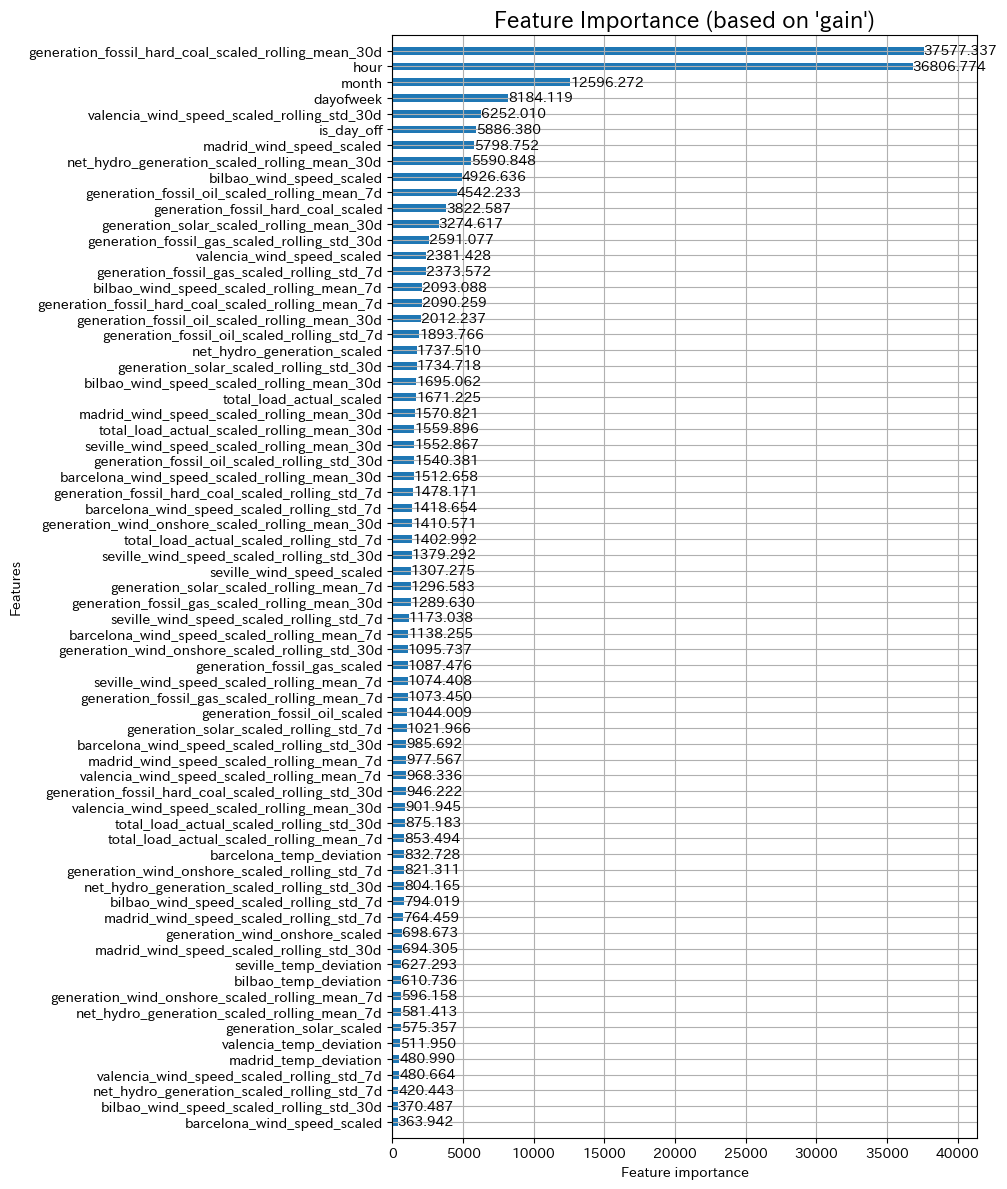

In [ ]:
# --- 特徴量重要度の可視化 ---

# グラフのサイズを調整
plt.figure(figsize=(10, 12))

# LightGBMに組み込まれている関数で、特徴量重要度をプロット
lgb.plot_importance(
    model_lgbm,
    height=0.5,         # バーの高さ
    figsize=(10, 12),     # グラフのサイズ
    importance_type='gain' # ★重要度の種類を 'gain' に指定
)

plt.title("Feature Importance (based on 'gain')", fontsize=16)
plt.tight_layout() # レイアウトを自動調整
plt.show()


In [ ]:
# --- 特徴量重要度の取得（修正版） ---

# .feature_importances_ は属性なので、() をつけずに呼び出す
# importance_typeはモデル初期化時に指定済み
feature_importance_df = pd.DataFrame({
    'feature': model_lgbm.feature_name_,
    'importance': model_lgbm.feature_importances_, # ← () を削除
}).sort_values('importance', ascending=False) # 重要度で並べ替え

# 全ての行を表示する設定
pd.set_option('display.max_rows', None)

print(f"--- 全特徴量の重要度 (importance_type='{model_lgbm.importance_type}') ---")
print(feature_importance_df)

# 設定を元に戻す
pd.reset_option('display.max_rows')


# もし、gainとsplitの両方を見たい場合は、モデルを2つ学習させるか、
# 一度学習させた後で、モデルの属性を書き換える必要があります。
# (ただし、通常はどちらか一方の指標で評価します)

# 例：splitの重要度も取得する場合
model_lgbm.importance_type = 'split' # ここで属性を書き換える
feature_importance_df['importance_split'] = model_lgbm.feature_importances_

--- 全特徴量の重要度 (importance_type='split') ---
                                              feature  importance
18                                               hour         322
20                                              month         133
19                                          dayofweek         101
8                            bilbao_wind_speed_scaled          70
54  generation_fossil_hard_coal_scaled_rolling_mea...          67
6                            madrid_wind_speed_scaled          65
48           generation_solar_scaled_rolling_mean_30d          52
21                                         is_day_off          50
31  generation_fossil_hard_coal_scaled_rolling_std_7d          43
4                  generation_fossil_hard_coal_scaled          43
29        generation_fossil_gas_scaled_rolling_std_7d          42
32       generation_fossil_oil_scaled_rolling_mean_7d          41
68       net_hydro_generation_scaled_rolling_mean_30d          40
38           bilbao_wind_speed_sc

xgboostを試す

In [ ]:
# # ライブラリを最新版にアップグレードする
# !pip install --upgrade xgboost

In [ ]:
# import xgboost as xgb
# # 他のライブラリ（pandas, sklearnなど）は既にインポート済みとします

# # --- XGBoostのためのデータ準備 (カテゴリ変数の型変換) ---
# # XGBoostにカテゴリ変数を正しく認識させるため、事前にデータ型を 'category' に変更します。
# categorical_cols = ['is_day_off', "hour", "month"]

# # .copy() を使って SettingWithCopyWarning を回避
# X_train = X_train.copy()
# X_val = X_val.copy()
# # X_test も同様に
# # X_test = X_test.copy()

# for col in categorical_cols:
#     X_train[col] = X_train[col].astype('category')
#     X_val[col] = X_val[col].astype('category')
#     # X_test[col] = X_test[col].astype('category')


# # 1. XGBoostモデルの初期化
# # ★★★ eval_metric を .fit() からこちらに移動します ★★★
# model_xgb = xgb.XGBRegressor(
#     objective='reg:absoluteerror',  # LightGBMの 'regression_l1' (MAE) に相当
#     random_state=42,
#     n_estimators=100,              # 木の数の上限
#     learning_rate=0.05,
#     enable_categorical=True,        # カテゴリ変数を有効にする設定
#     eval_metric='rmse'              # ← ここで評価指標を指定
# )

# # 2. モデルの学習
# print("Training XGBoost")
# model_xgb.fit(
#     X_train,
#     y_train,
#     eval_set=[(X_val, y_val)],
#     # # eval_metric='rmse',         # ← ここからは削除
#     # early_stopping_rounds=50,       # 50回連続でスコアが改善しなければ停止
#     verbose=True                    # 学習の過程を表示
# )
# print("XGBoost model trained.")

Trainデータ全てを使用して再学習

In [ ]:
# CVで見つけた最適な学習回数を使うのがベストプラクティス
# （実際には各Foldのmodel.best_iteration_を記録して平均を取る）
best_n_estimators = 80 # 仮

# 最適なパラメータで最終モデルを初期化
final_model = lgb.LGBMRegressor(
    objective='regression_l1',
    random_state=42,
    n_estimators=best_n_estimators, # CVで見つけた回数を指定
    # learning_rateなど、チューニングした他のパラメータも設定
    reg_alpha=0.1,  # L1正則化の強さを指定（値が大きいほどペナルティが強くなる）
    reg_lambda=5.0 # L2正則化の強さを指定（値が大きいほどペナルティが強くなる）
)

# train_dfの全データを使って学習（早期停止は不要）
final_model.fit(X, y, categorical_feature=categorical_features)
print("Final model trained.")

# --- 5. 最終的なテストデータに対する予測の作成 ---
all_train_data_final_test_predictions = final_model.predict(X_test)

print("\n最終的なテストデータへの予測値（最初の5件）:")
print(all_train_data_final_test_predictions[:5])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16626
[LightGBM] [Info] Number of data points in the train set: 26280, number of used features: 70
[LightGBM] [Info] Start training from score 55.930000
Final model trained.

最終的なテストデータへの予測値（最初の5件）:
[33.3708203  36.21611211 34.20368084 32.60065255 31.68445421]


# テストデータ予測と提出
- テストデータに対する予測
- 提出ファイルの作成

In [ ]:
# y_test_pred = model_lgbm.predict(X_test)

In [ ]:
# sample_submission に書き込み & 保存
# sample_submission_df[1] = y_test_pred

In [ ]:
sample_submission_df[1] = all_train_data_final_test_predictions

In [ ]:
sample_submission_df

,0,1
0,2018-01-01 00:00:00+01:00,33.370820
1,2018-01-01 01:00:00+01:00,36.216112
2,2018-01-01 02:00:00+01:00,34.203681
3,2018-01-01 03:00:00+01:00,32.600653
4,2018-01-01 04:00:00+01:00,31.684454
...,...,...
8755,2018-12-31 19:00:00+01:00,63.278933
8756,2018-12-31 20:00:00+01:00,64.451338
8757,2018-12-31 21:00:00+01:00,62.806937
8758,2018-12-31 22:00:00+01:00,58.271569


In [ ]:
sample_submission_df.to_csv(submission_path+'cross_validation_0611_09:38.csv', header=False, index=False)